In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import utils_attributes_analysis
import utils

## Table of contents:
* [Dataset setup and description](#dataset)
* [Discretization of chunk numerical columns](#discretization)
* [Chunk attributes](#chunk)
    * [Distribution of chunk categorical attributes](#chunk_categorical_distribution)
    * [Distribution of chunk continuous attributes](#chunk_continuous_distribution)
    * [Distribution of chunk continuous attributes per developerdecision](#chunk_continuous_decision)
    * [Correlation between chunk continuous attributes and developerdecision](#correlation_chunk)
    * [Probability plots for chunk continuous attributes](#chunk_probability)
    * [Lift analysis for Chunk level attributes](#chunk_lift)
* [File attributes](#file)
    * [Distribution of file categorical attributes](#file_categorical_distribution)
    * [Lift analysis for File level attributes](#file_lift)
* [Merge attributes](#merge)
    * [Distribution of merge categorical attributes](#merge_categorical_distribution)
    * [Lift analysis for Merge level attributes](#merge_lift)

### Dataset setup and description <a class="anchor" id="dataset"></a>

In [2]:
df = pd.read_csv("../../data/dataset-training.csv")
df = df[df['developerdecision']!='UnknownConcatenation']
df.head()

,chunk_id,developerdecision,line_start,line_end,line_separator,kind_conflict,url,project,project_user,project_name,path,file_name,sha,leftsha,rightsha,basesha,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc,Class declaration,Throw statement,Class signature,Do statement,For statement,Attribute,While statement,Switch statement,Package declaration,Method declaration,Variable,TypeDeclarationStatement,Blank,Enum signature,Enum value,Annotation,Continue statement,Interface signature,Method interface,Try statement,Break statement,Other,Interface declaration,If statement,Cast expression,Import,Synchronized statement,Assert statement,Array initializer,Array access,Static initializer,Annotation declaration,Method invocation,Method signature,Comment,Catch clause,Return statement,Case statement,Enum declaration
0,780020,Manual,171,257,207,"Case statement, Comment, For statement, Method...",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/FactA...,FactAdder.java,9219deb426f35f7409a6eb6185c6486b5da4e6fe,a100b1d71caaa176474e7a630972f6679660d8da,961ff4fc69295b67ca9e94c86d334834f6c15020,fee6dbeac4d90fae3b701e3544c6e576aacdb5b2,9.0,106.0,3073.0,3610.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,2.0,3.0,4.0,15.0,84.0,0.269231,3.0,312.0,35.0,0.416667,49.0,0.583333,4.121782,4.432338,1.0,1.0,2.0,0.0,0.0,13.0,1.0,39.0,4.0,1.0,0.333333,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0
1,780349,Manual,103,118,112,"Attribute, Comment",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/AnkiD...,AnkiDroid.java,24d026e6424e9df66bd8755ec5c6f82fcea65c8b,aed3df5e3adb552ad6c967ee3cc906bd7f2880ff,2093128dcbaaa74a1972cf806870804e3025c8b5,f112e09e4019f812e11bf8721f8638f96207b180,3655.0,5911.0,1528.0,16812.0,0.0,32.0,18.0,1.0,4.0,0.0,2.0,12.0,19.0,5.0,17.0,3.0,12.0,1.0,1.0,171.0,13.0,0.007715,1.0,1685.0,8.0,0.615385,5.0,0.384615,115.110104,116.961458,3.0,8.0,11.0,1.0,1.0,65.0,67.0,79.0,74.0,1.0,0.333333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,778509,Version 2,267,307,282,"Comment, If statement, Method invocation, Vari...",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/DeckT...,DeckTask.java,172c065f8ec739f660ac6bc4f21a6103b25a2464,c4e1eac57e1fbbf6222ca91d5be01988f6d02c67,8d7fa2935ffa1dba599d401d9544e0afd6e412f2,b48348fdc1933b63855c72a10bd44a59453c022c,15125.0,40397.0,9860.0,8411.0,108.0,115.0,28.0,7.0,13.0,1.0,3.0,14.0,79.0,12.0,23.0,9.0,25.0,4.0,8.0,94.0,38.0,0.037811,2.0,1005.0,14.0,0.368421,24.0,0.631579,114.542928,116.028727,1.0,11.0,12.0,1.0,1.0,28.0,526.0,68.0,889.0,1.0,0.166667,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,778739,Combination,39,47,44,Import,https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/CardE...,CardEditor.java,f939a01b341a6a09a4bf6b1b25fc2275c74636a8,a7b7898292bc2ab73502b829568e176d30fc32d8,16011759134702ff0bb04dd5cd65d579ef36f064,df907cb0e4722e67316d5eb48ec2f7551660d0e2,973.0,2265.0,10742.0,8776.0,5.0,12.0,3.0,1.0,0.0,0.0,0.0,2.0,14.0,3.0,11.0,0.0,15.0,1.0,1.0,62.0,6.0,0.009317,1.0,644.0,4.0,0.666667,2.0,0.333333,49.845961,57.456759,1.0,7.0,8.0,1.0,1.0,19.0,63.0,59.0,75.0,1.0,0.0

In [3]:
total_chunks = len(df)
total_projects = len(pd.unique(df['project']))
total_merges = len(pd.unique(df['sha']))
print(f"The dataset has {total_merges} merges with {total_chunks} chunks from {total_projects} projects.")

The dataset has 4316 merges with 56241 chunks from 29 projects.


In [4]:
df.describe()

,chunk_id,line_start,line_end,line_separator,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc,Class declaration,Throw statement,Class signature,Do statement,For statement,Attribute,While statement,Switch statement,Package declaration,Method declaration,Variable,TypeDeclarationStatement,Blank,Enum signature,Enum value,Annotation,Continue statement,Interface signature,Method interface,Try statement,Break statement,Other,Interface declaration,If statement,Cast expression,Import,Synchronized statement,Assert statement,Array initializer,Array access,Static initializer,Annotation declaration,Method invocation,Method signature,Comment,Catch clause,Return statement,Case statement,Enum declaration
count,5.624100e+04,56241.000000,56241.000000,56241.000000,56241.000000,5.624100e+04,5.624100e+04,5.624100e+04,53611.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,53616.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,50901.000000,42644.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.00000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000,56241.000000
mean,1.162030e+06,8470.753489,8498.274853,8481.438595,3628.796056,4.768173e+04,6.254152e+04,1.187983e+05,8.309750,406.560303,207.740794,11.904714,26.208282,22.657421,19.429704,91.980370,312.433278,106.998471,183.841361,16.187906,506.544816,2.300060,3.806345,1643.686269,25.695557,0.038855,2.406931,15699.612951,9.537060,0.493898,16.158497,0.505990,58.546401,59.682937,37.034931,3.736017,40.770948,2.194810,0.856329,708.488045,160.554488,1740.774543,485.382586,0.980904,0.525975,0.013371,0.007948,0.014705,0.002934,0.022741,0.187479,0.005352,0.011113,0.009868,0.089863,0.202628,0.000338,0.016305,0.000356,0.001671,0.052844,0.000391,0.001102,0.014669,0.02155,0.010508,0.015505,0.001671,0.214559,0.026262,0.089134,0.008908,0.001903,0.002311,0.006952,0.002436,0.000071,0.405078,0.108551,0.358582,0.008659,0.052044,0.018190,0.000729
std,2.233468e+05,21033.525641,21029.124596,21032.067176,13981.484314,3.111554e+05,2.679819e+05,2.748542e+05,20.846991,862.008678,549.942471,26.010594,49.993931,49.195670,37.564834,216.172037,629.757917,207.782047,373.038221,31.648065,1303.049597,9.429353,24.093358,3264.323036,207.670106,0.108744,1.137982,34392.059789,92.780977,0.251875,132.010018,0.251877,213.737401,214.137207,63.356058,6.430939,63.269015,4.553917,0.413247,1177.529274,590.657343,1833.755662,786.425113,0.139986,0.444083,0.114859,0.088797,0.120369,0.054086,0.149079,0.390299,0.072962,0.104831,0.098849,0.285988,0.401961,0.018377,0.126646,0.018855,0.040849,0.223724,0.019774,0.033184,0.120225,0.14521,0.101971,0.123550,0.040849,0.410520,0.159915,0.284940,0.093962,0.043577,0.048023,0.083090,0.049296,0.008433,0.490912,0.311077,0.479588,0.092652,0.2

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = list(df.select_dtypes(include=numerics))
not_attributes_columns = ['chunk_id', 'line_start', 'line_end', 'line_separator']
float_columns = ['chunkRelSize','self_conflict_perc','chunk_left_rel_size', 'chunk_right_rel_size']
numeric_columns = [elem for elem in numeric_columns if elem not in not_attributes_columns]
numeric_columns = [elem for elem in numeric_columns if elem not in float_columns]
last_not_boolean_column = "self_conflict_perc"
last_not_boolean_column_index = list(df.columns).index(last_not_boolean_column)
boolean_columns = list(df.columns)[last_not_boolean_column_index+1:]
numeric_columns = [elem for elem in numeric_columns if elem not in boolean_columns]
print(numeric_columns)

['left_lines_added', 'left_lines_removed', 'right_lines_added', 'right_lines_removed', 'conclusion_delay', 'keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve', 'keyword_document', 'keyword_refactor', 'keyword_update', 'keyword_add', 'keyword_remove', 'keyword_use', 'keyword_delete', 'keyword_change', 'leftCC', 'rightCC', 'fileCC', 'chunkAbsSize', 'chunkPosition', 'fileSize', 'chunk_left_abs_size', 'chunk_right_abs_size', 'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2', 'Different devs', 'Same devs', 'Devs intersection', 'Commits 1', 'Commits 2', 'Changed files 1', 'Changed files 2', 'Changed files intersection']


### Discretization of chunk numerical columns <a class="anchor" id="discretization"></a>

In [6]:
discretized, labels = utils.get_discretized_df(df, numeric_columns)
discretized

,chunk_id,developerdecision,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_right_abs_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection
0,780020,Manual,Few (<10),Hundreds,Thousands,Thousands,Zero,Few (<10),Few (<10),Zero,Zero,Zero,Zero,Zero,Few (<10),Zero,Few (<10),Zero,Few (<10),Few (<10),Few (<10),Tens,Tens,Few (<10),Hundreds,Tens,Tens,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Zero,Zero,Tens,Few (<10),Tens,Few (<10),Few (<10)
1,780349,Manual,Thousands,Thousands,Thousands,Tens of thousands,Zero,Tens,Tens,Few (<10),Few (<10),Zero,Few (<10),Tens,Tens,Few (<10),Tens,Few (<10),Tens,Few (<10),Few (<10),Hundreds,Tens,Few (<10),Thousands,Few (<10),Few (<10),Hundreds,Hundreds,Few (<10),Few (<10),Tens,Few (<10),Few (<10),Tens,Tens,Tens,Tens,Few (<10)
2,778509,Version 2,Tens of thousands,Tens of thousands,Thousands,Thousands,Hundreds,Hundreds,Tens,Few (<10),Tens,Few (<10),Few (<10),Tens,Tens,Tens,Tens,Few (<10),Tens,Few (<10),Few (<10),Tens,Tens,Few (<10),Thousands,Tens,Tens,Hundreds,Hundreds,Few (<10),Tens,Tens,Few (<10),Few (<10),Tens,Hundreds,Tens,Hundreds,Few (<10)
3,778739,Combination,Hundreds,Thousands,Tens of thousands,Thousands,Few (<10),Tens,Few (<10),Few (<10),Zero,Zero,Zero,Few (<10),Tens,Few (<10),Tens,Zero,Tens,Few (<10),Few (<10),Tens,Few (<10),Few (<10),Hundreds,Few (<10),Few (<10),Tens,Tens,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Tens,Tens,Tens,Tens,Few (<10)
4,780250,Version 2,Tens,Hundreds,Tens,Tens,Zero,Zero,Zero,Zero,Zero,Zero,Few (<10),Zero,Zero,Zero,Zero,Zero,Few (<10),Few (<10),Zero,Hundreds,Tens,Few (<10),Thousands,Tens,Zero,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Zero,Zero,Few (<10),Few (<10),Few (<10),Tens,Few (<10)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56236,1657774,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Tens,Few (<10),Few (<10),Hundreds,Few (<10),Zero,Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Thousands,Few (<10),Thousands,Thousands,Few (<10)
56237,1657854,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Hundreds,Few (<10),Few (<10),Hundreds,Few (<10),Zero,Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Thousands,Few (<10),Thousands,Thousands,Few (<10)
56238,1656283,Combination,Tens,Tens,Tens of thousands,Hundreds of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Hundreds,Tens,Few (<10),Hundreds,Tens,Zero,Few (<10),Few (<10),Hundreds,Few (<10),Hundreds,Zero,Zero,Thousands,Few (<10),Thousands,Few (<10),Few (<10)
56239,1657886,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Tens,Tens,Tens,Tens,Hundreds,Hundreds,Hundreds,Hundreds,Tens,Thousands,Few (<10),Zero,Hundreds,Few (<10),Few (<10),Thousands,Few (<10),Zero,Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Thousands,Few (<10),Thousands,Thousands,Few (<10)


In [7]:
chunk_columns_categorical = ['leftCC', 'rightCC', 'chunkAbsSize', 'chunk_left_abs_size', 'chunk_right_abs_size' ]
chunk_columns_float = ['chunkRelSize', 'self_conflict_perc', 'chunk_left_rel_size', 'chunk_right_rel_size', 'chunkPosition' ]


file_columns_categorical = ['fileCC', 'fileSize']
# file_columns_float = []

merge_columns_categorical = ['left_lines_added', 'left_lines_removed', 'right_lines_added', 'right_lines_removed', 'conclusion_delay']
merge_columns_categorical.extend(['keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve', 'keyword_document'])
merge_columns_categorical.extend(['keyword_refactor', 'keyword_update','keyword_add', 'keyword_remove', 'keyword_use'])
merge_columns_categorical.extend(['keyword_delete', 'keyword_change', 'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2'])
merge_columns_categorical.extend(['Different devs', 'Same devs', 'Devs intersection', 'Commits 1', 'Commits 2'])
merge_columns_categorical.extend(['Changed files 1','Changed files 2', 'Changed files intersection'])
# merge_columns_float = []

 

## Chunk attributes  <a class="anchor" id="chunk"></a>

### Distribution of chunk categorical attributes <a class="anchor" id="chunk_categorical_distribution"></a>

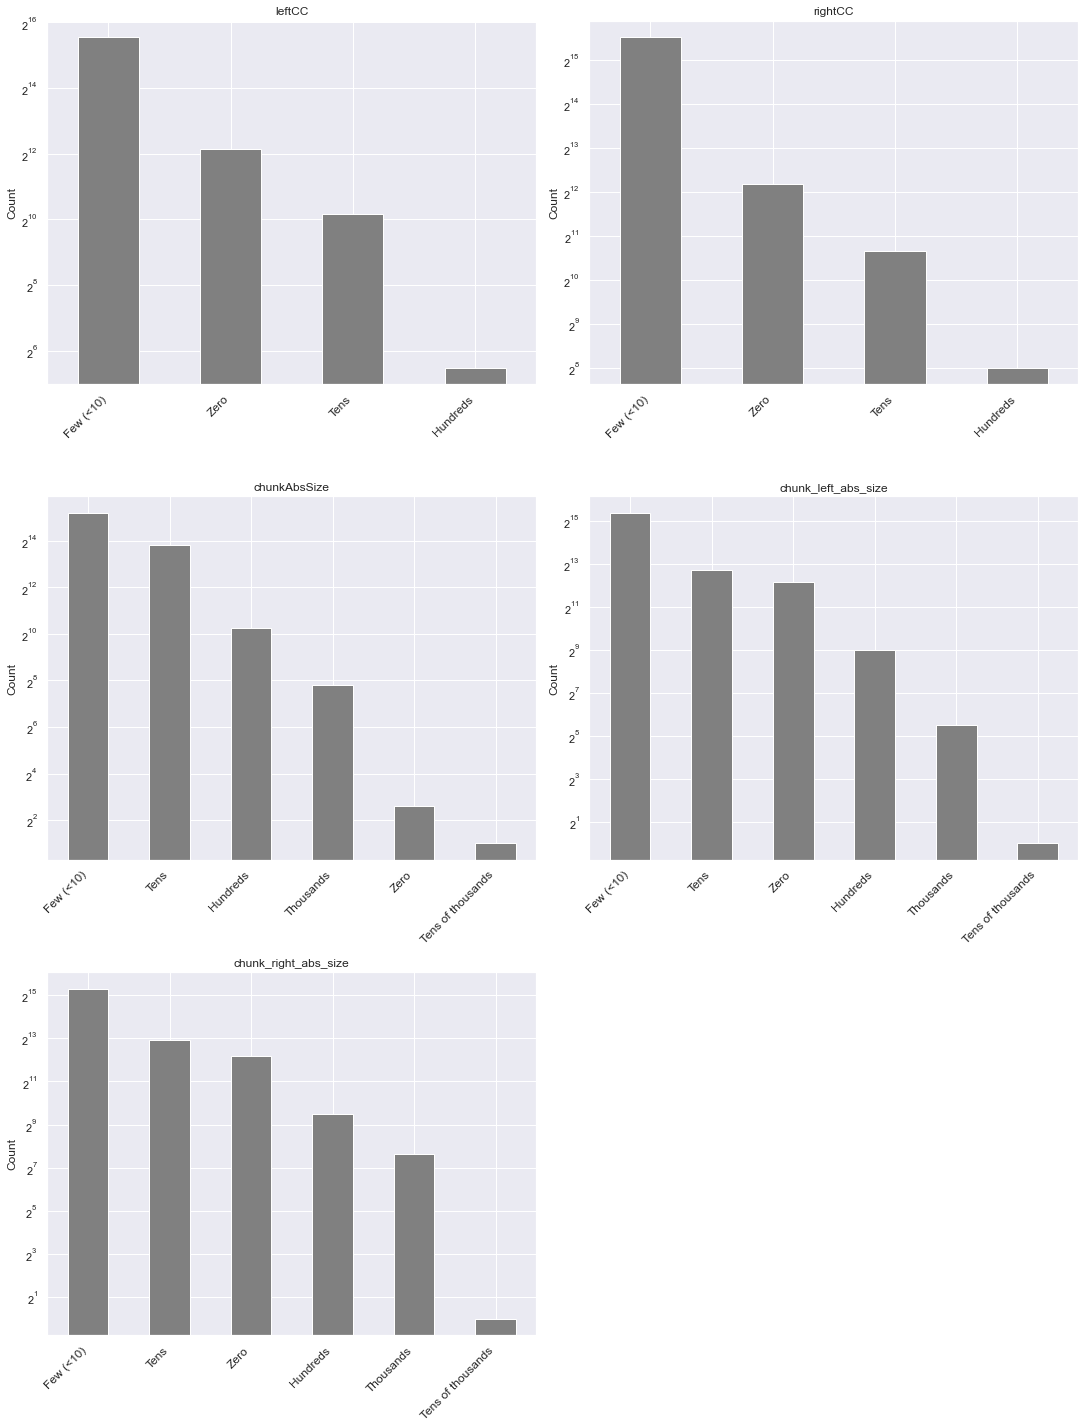

In [8]:
utils_attributes_analysis.count_plot_categorical(chunk_columns_categorical, discretized, 2, True, 2)

### Distribution of chunk continuous attributes <a class="anchor" id="chunk_continuous_distribution"></a>

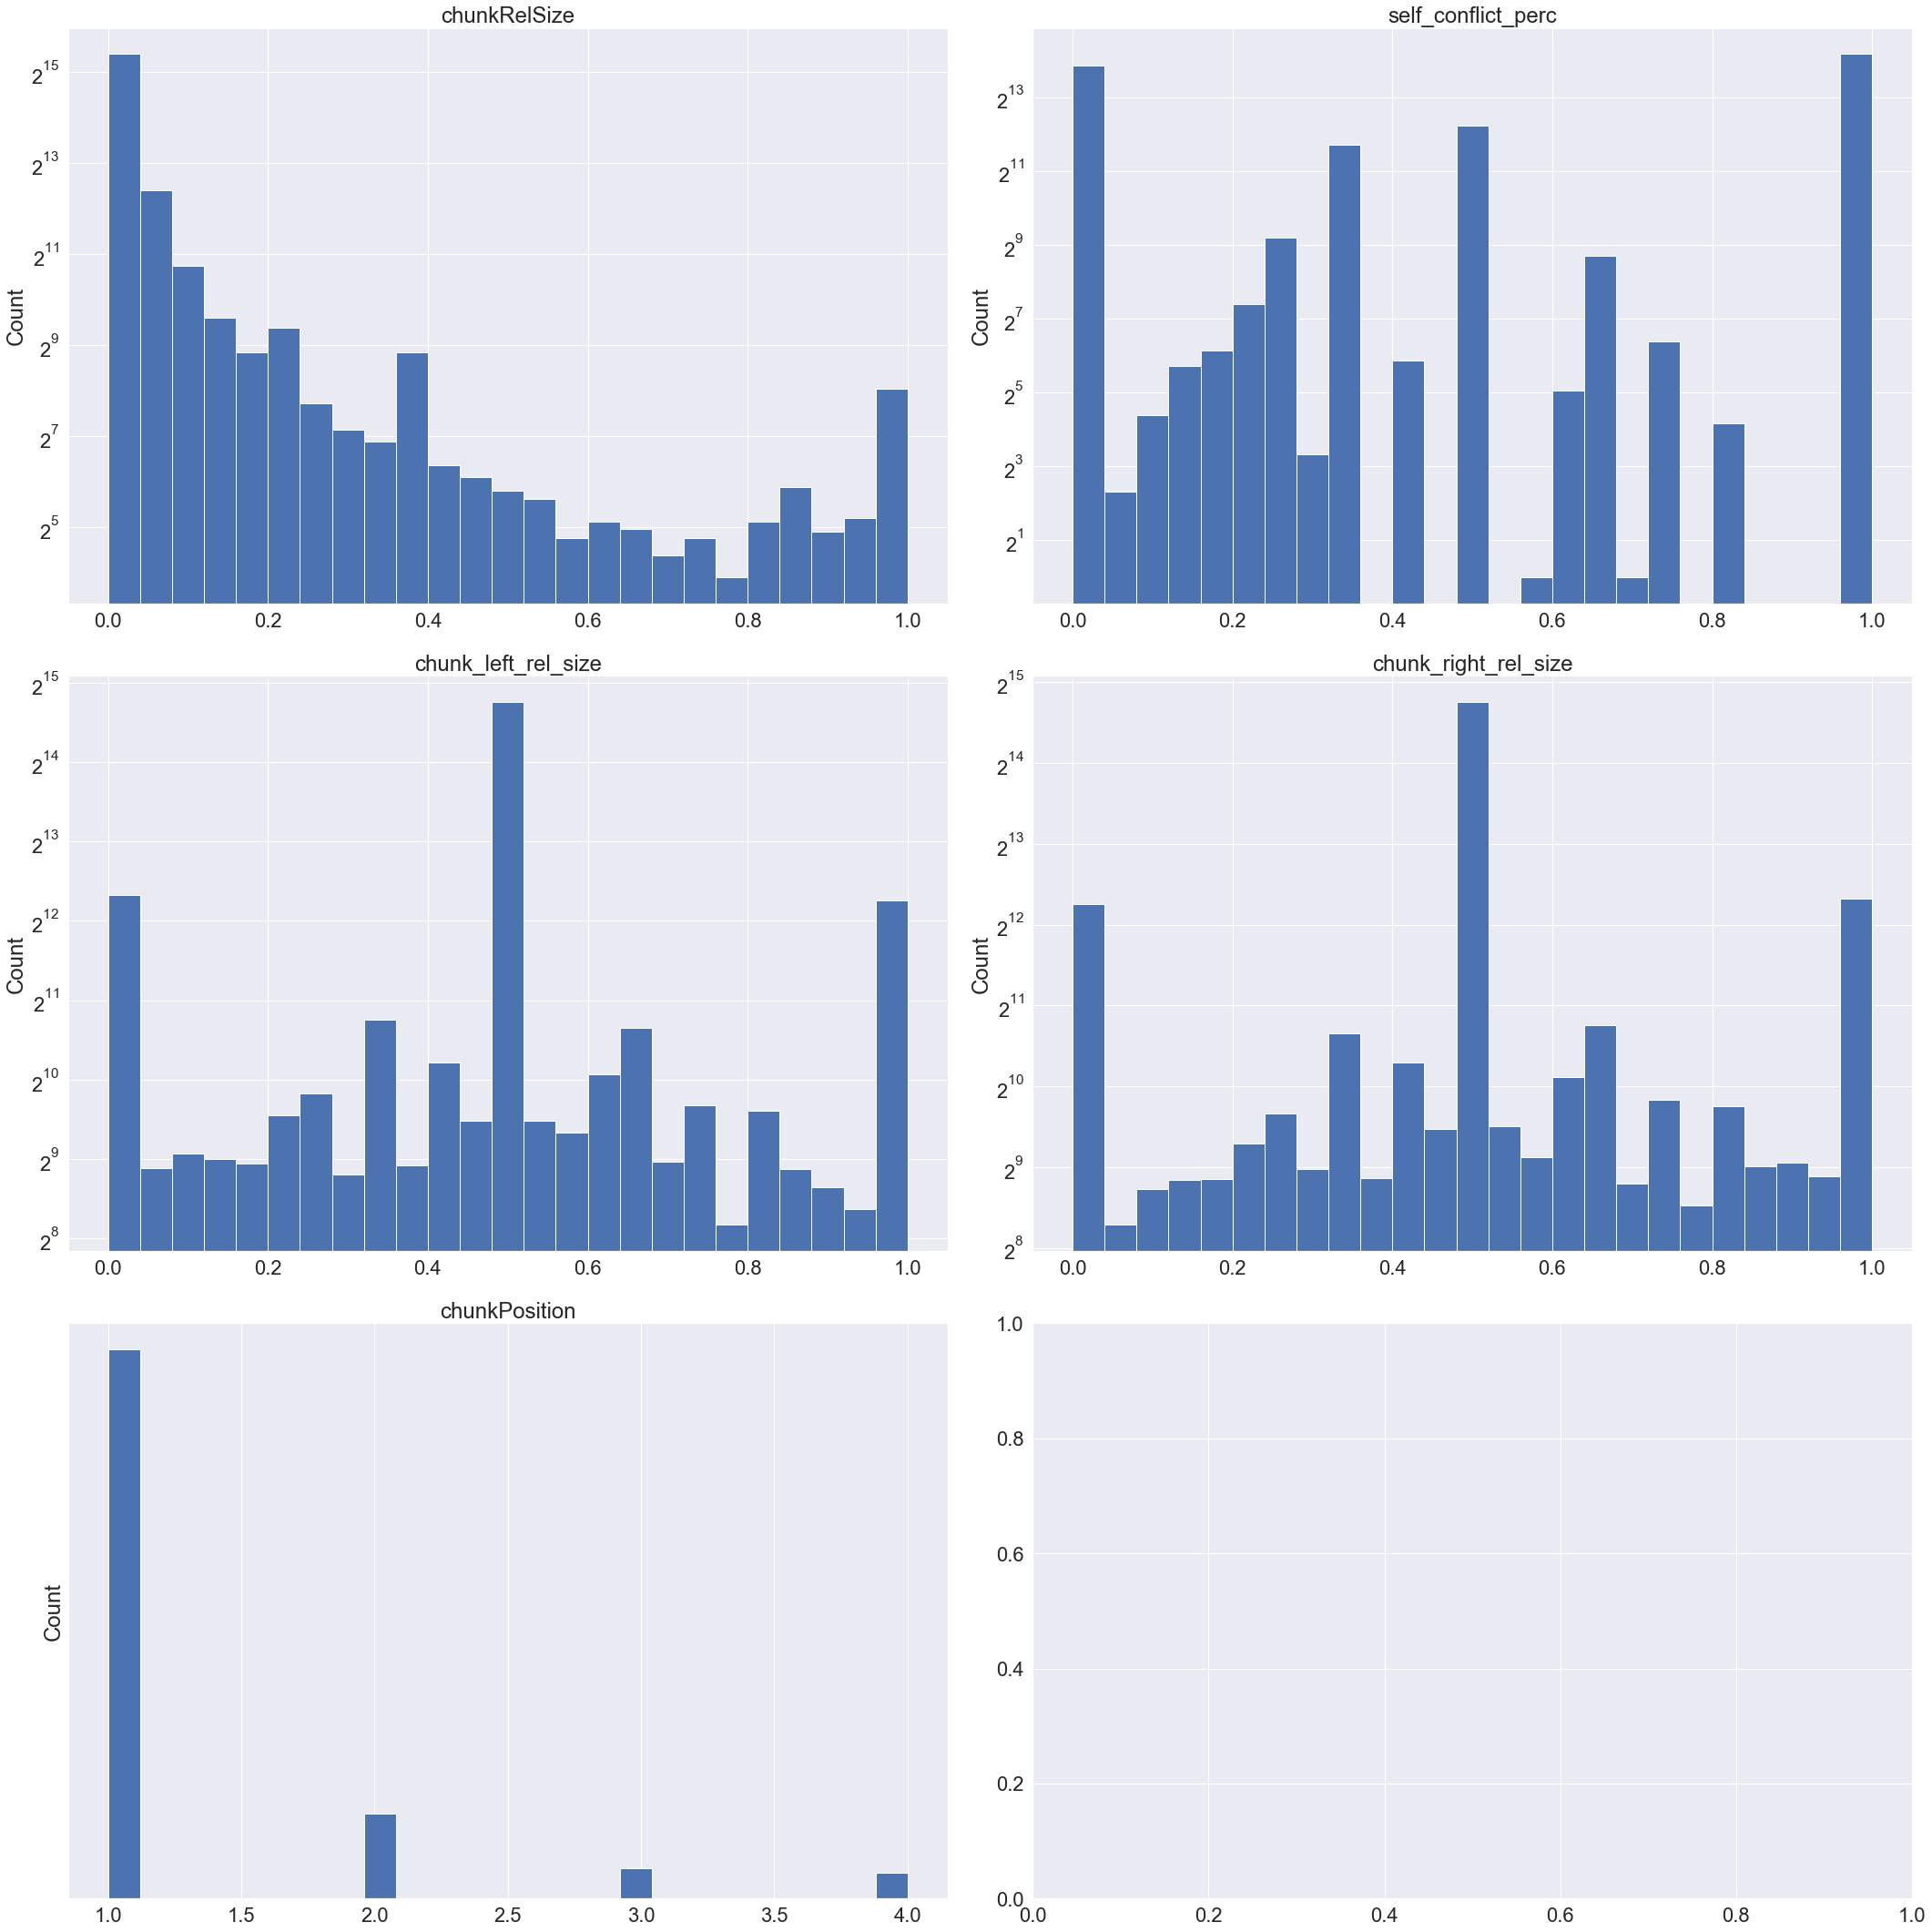

In [9]:
utils_attributes_analysis.hist_plot(chunk_columns_float, df, 2, True, 2)

### Distribution of chunk continuous attributes per developerdecision <a class="anchor" id="chunk_continuous_decision"></a>

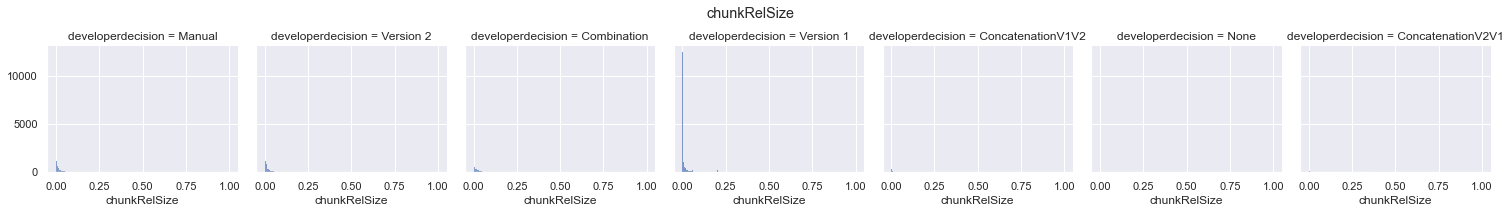

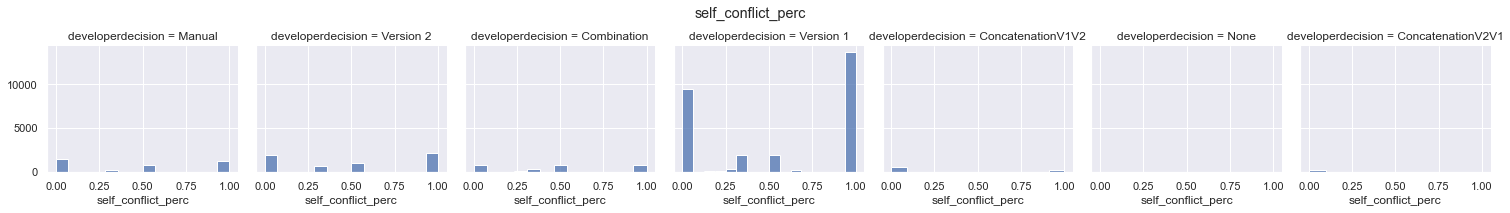

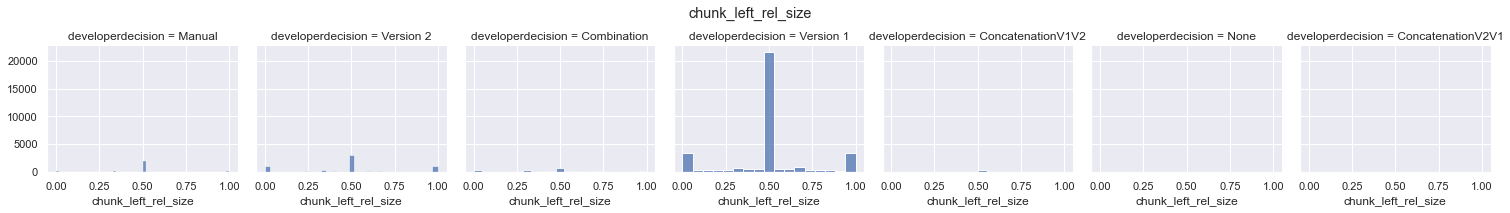

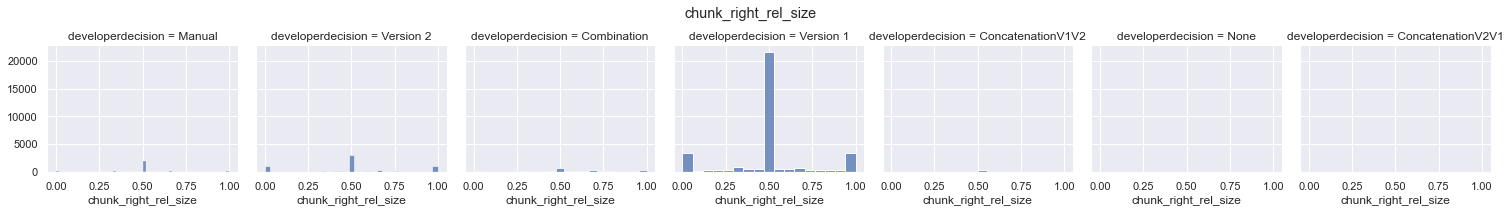

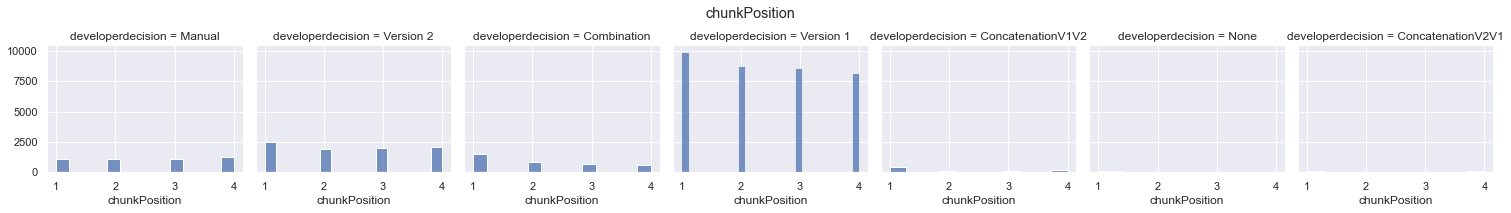

In [10]:
utils_attributes_analysis.hist_plot_by_category(chunk_columns_float, df, 'developerdecision')

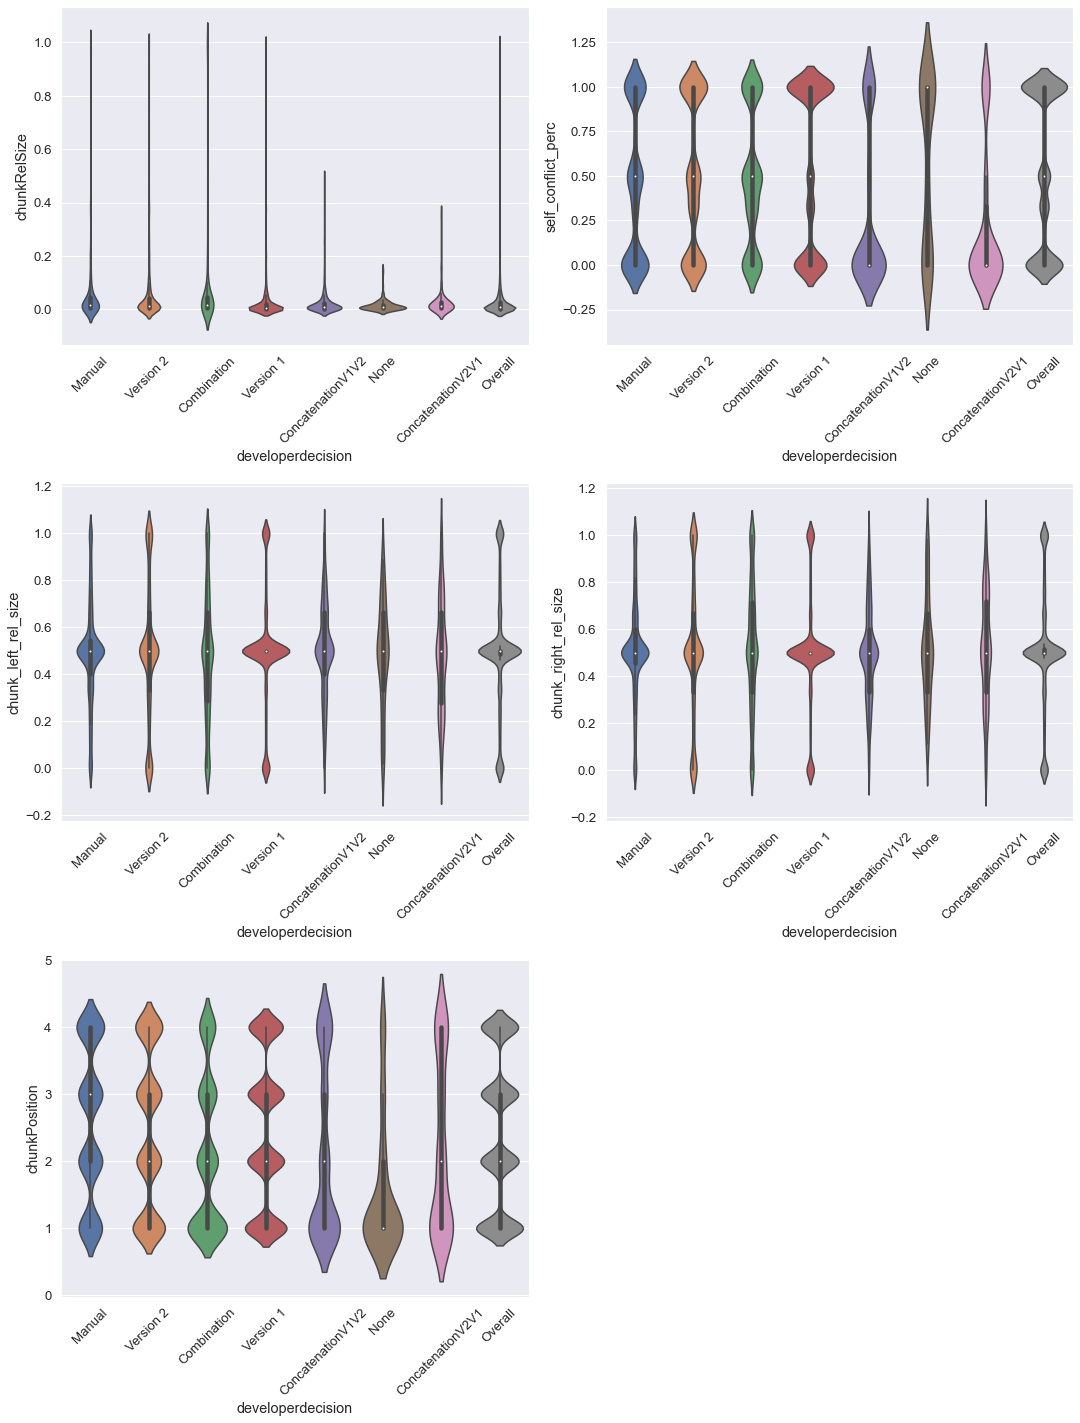

In [11]:
utils_attributes_analysis.violin_by_category(chunk_columns_float, df, 'developerdecision')

### Correlation between chunk continuous attributes and developerdecision <a class="anchor" id="correlation_chunk"></a>

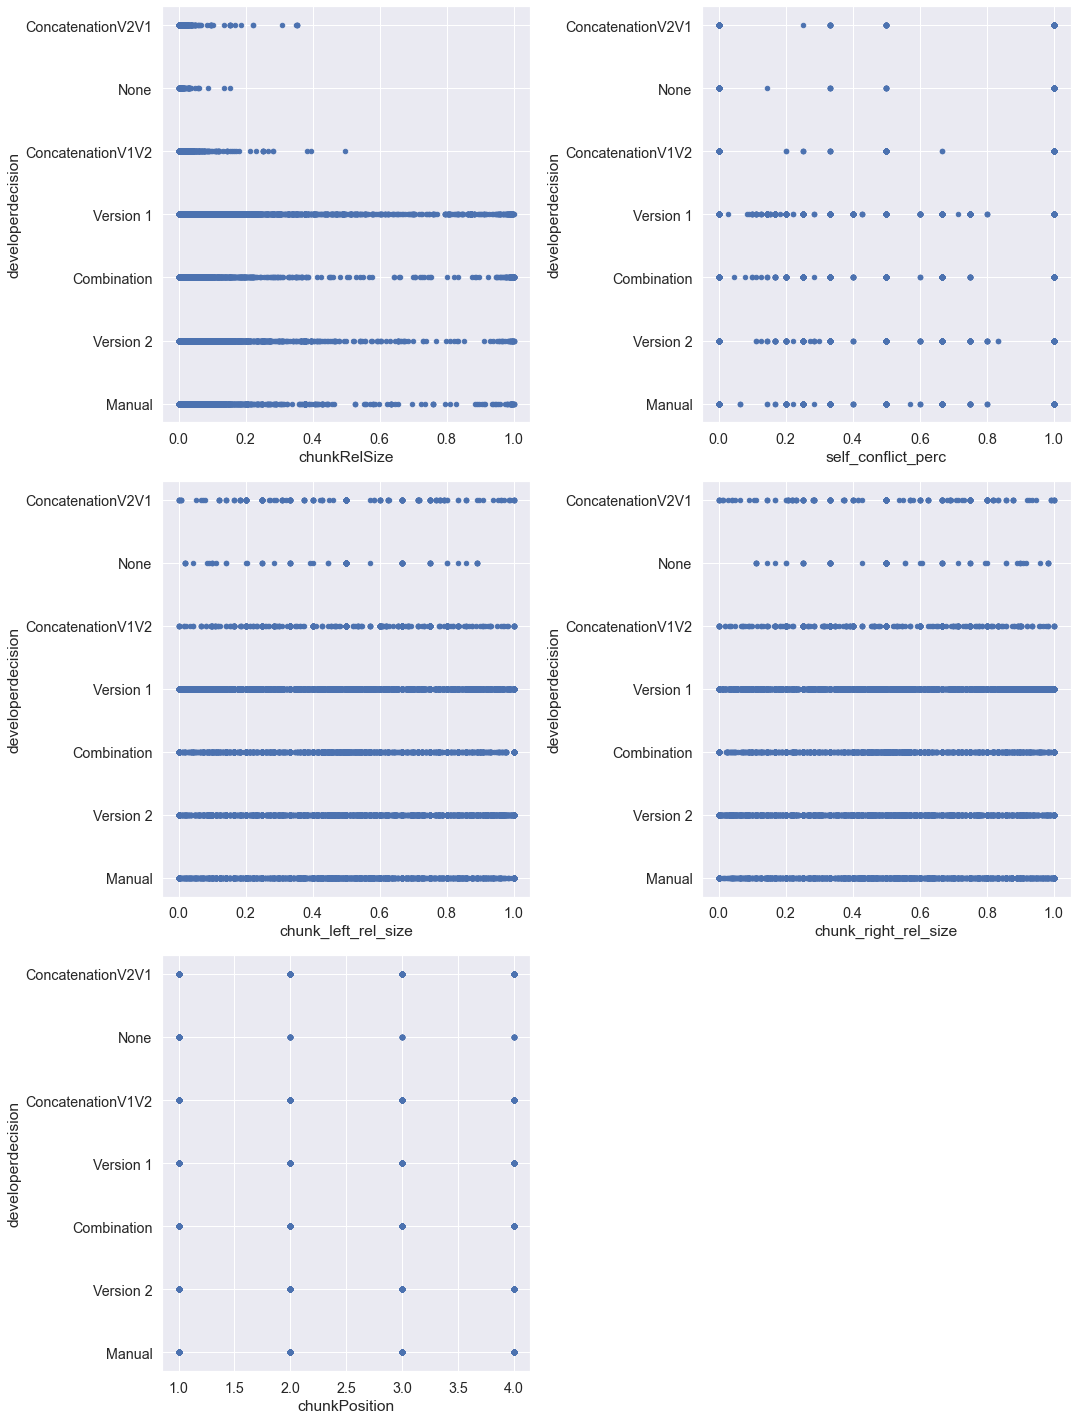

In [12]:
utils_attributes_analysis.scatter_by_category(chunk_columns_float, df, 'developerdecision')

### Probability plots for chunk continuous attributes <a class="anchor" id="chunk_probability"></a>

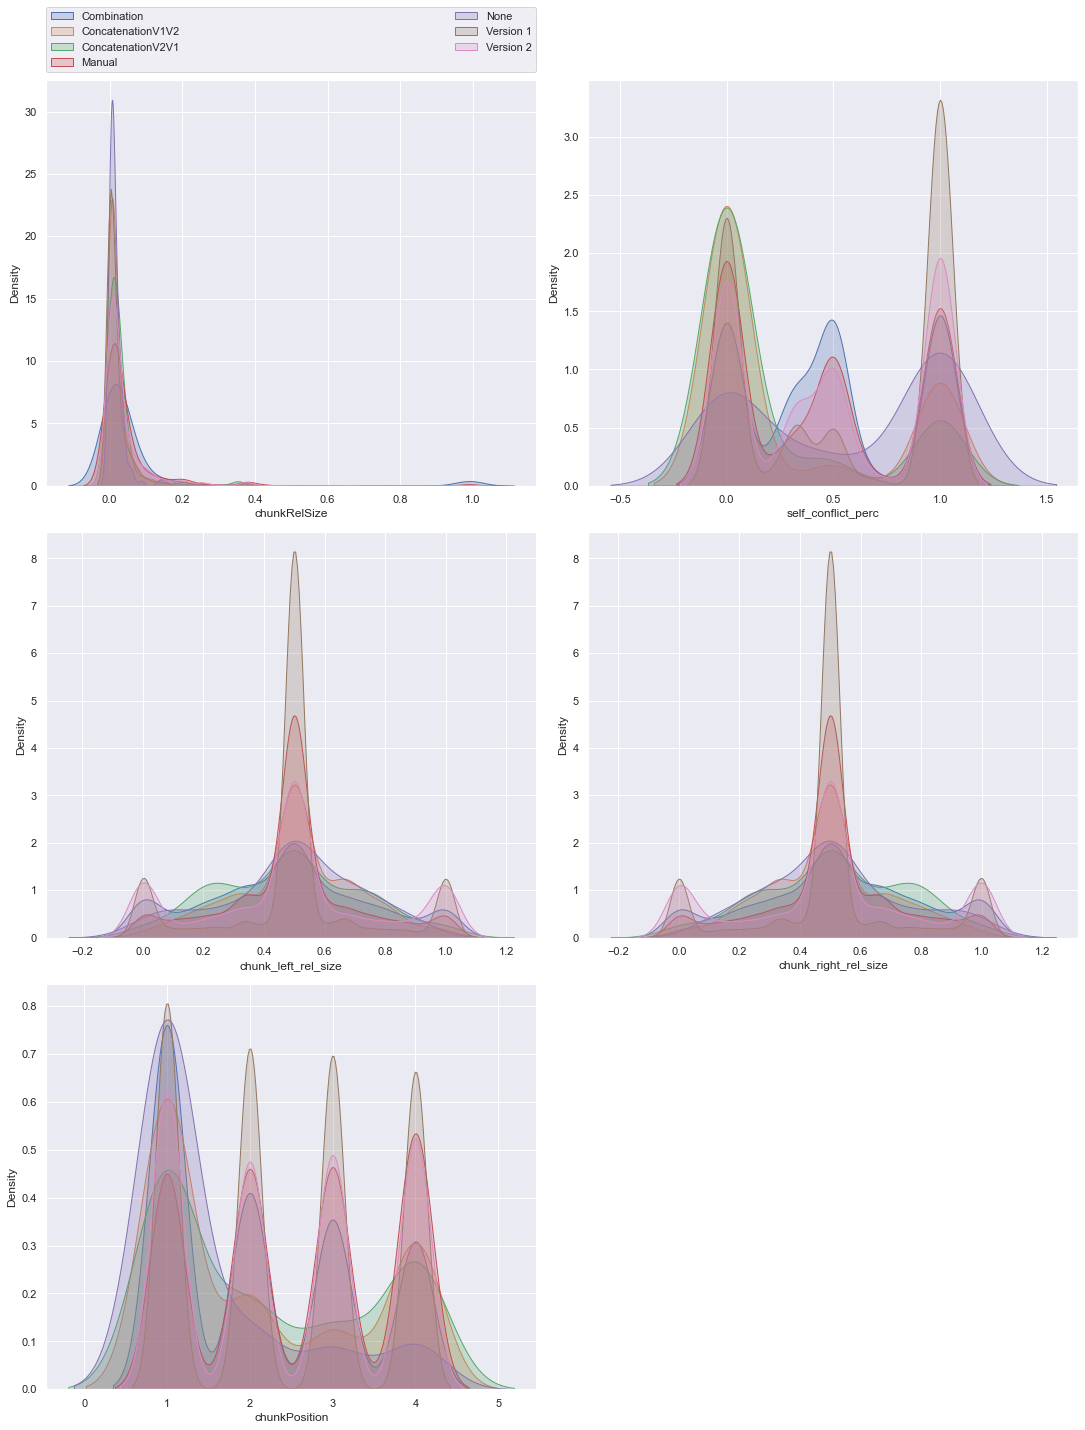

In [13]:
utils_attributes_analysis.density_by_category(chunk_columns_float, df, 'developerdecision', 2)

### Lift analysis for Chunk level attributes <a class="anchor" id="chunk_lift"></a>

In [14]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in chunk_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])    

In [15]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase.sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease.sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,chunk_right_abs_size=Tens of thousands => Comb...,14.969657,1.000000,1
0,chunk_left_abs_size=Tens of thousands => Combi...,14.969657,1.000000,1
1,chunk_left_abs_size=Thousands => Combination,8.649135,0.577778,26
0,leftCC=Hundreds => Combination,7.983817,0.533333,24
0,chunkAbsSize=Tens of thousands => Combination,7.484828,0.500000,1
1,chunkAbsSize=Tens of thousands => Manual,4.479927,0.500000,1
1,chunk_right_abs_size=Hundreds => None,4.097207,0.008451,6
2,chunk_left_abs_size=Hundreds => Combination,3.749796,0.250493,127
2,chunkAbsSize=Thousands => Combination,2.980684,0.199115,45
2,chunk_right_abs_size=Hundreds => Combination,2.740923,0.183099,130


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,leftCC=Zero => ConcatenationV1V2,0.086812,0.001321,6
0,chunk_left_abs_size=Zero => ConcatenationV1V2,0.086812,0.001321,6
1,chunk_left_abs_size=Hundreds => ConcatenationV1V2,0.129590,0.001972,1
0,rightCC=Zero => ConcatenationV1V2,0.141113,0.002148,10
0,chunk_right_abs_size=Zero => ConcatenationV1V2,0.141113,0.002148,10
1,leftCC=Hundreds => Version 1,0.175919,0.111111,5
1,chunk_right_abs_size=Thousands => Version 2,0.182537,0.030457,6
1,rightCC=Hundreds => Version 2,0.210701,0.035156,9
2,chunk_left_abs_size=Tens => None,0.217285,0.000448,3
2,chunk_right_abs_size=Zero => ConcatenationV2V1,0.220290,0.001289,6


## File attributes <a class="anchor" id="file"></a>

### Distribution of file categorical attributes <a class="anchor" id="file_categorical_distribution"></a>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


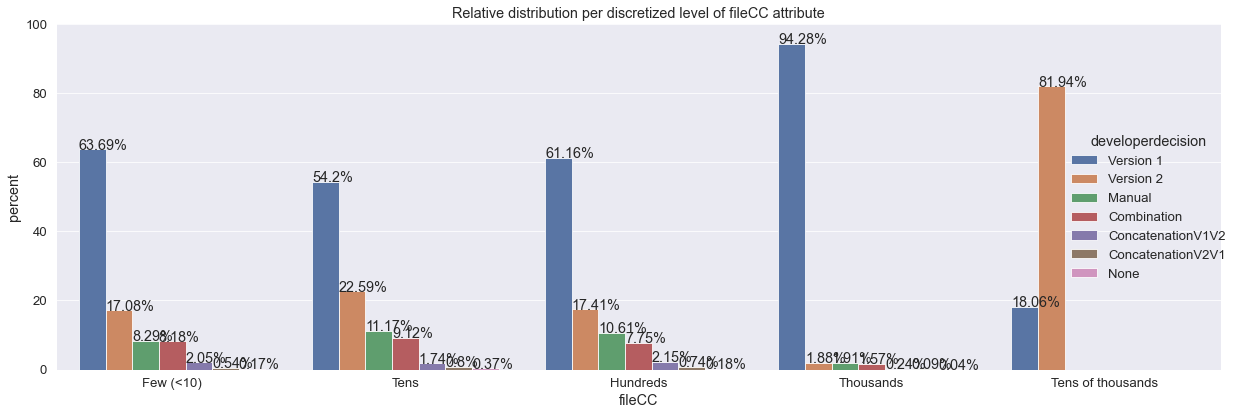

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


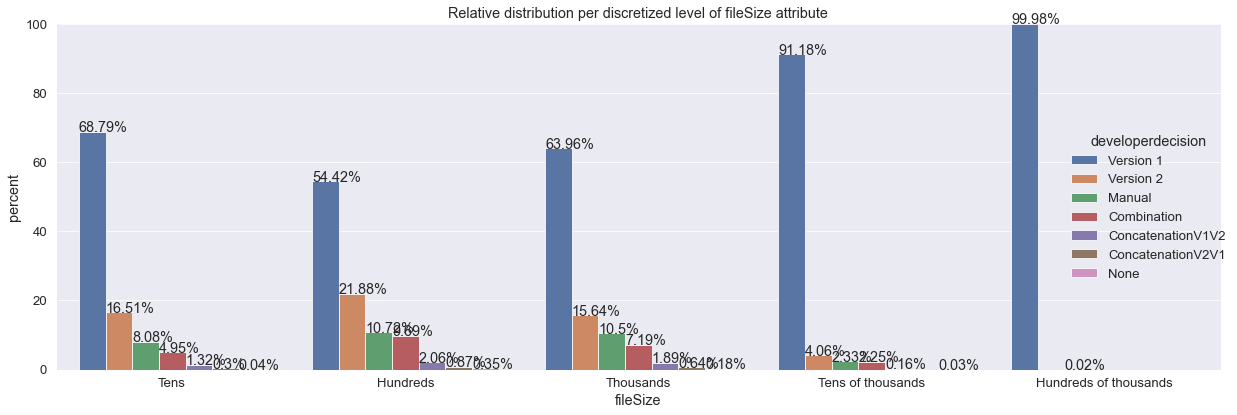

In [16]:
sns.set_context("paper", font_scale=1.5)



for categorical_feature in file_columns_categorical:
    x,y = categorical_feature, 'developerdecision'

    df1 = discretized.groupby(x, observed=True)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=6, aspect = 15/6)
    g.ax.set_ylim(0,100)
    g.ax.set_title(f"Relative distribution per discretized level of {categorical_feature} attribute")

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

    plt.tight_layout()
    plt.show()


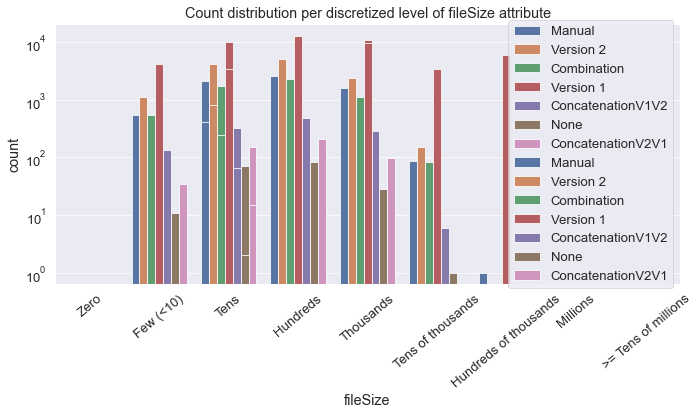

In [17]:
sns.set(font_scale=1)
sns.set_context("paper", font_scale=1.5)

plt.figure(figsize=(10,6))
for categorical_feature in file_columns_categorical:
    g = sns.countplot(x=categorical_feature, hue='developerdecision', data=discretized)
    g.set_yscale("log")
    g.set_title(f"Count distribution per discretized level of {categorical_feature} attribute")
    g.set_xticklabels(labels, rotation=40)

plt.legend(loc='right')
plt.tight_layout()
plt.show()


### Lift analysis for File level attributes <a class="anchor" id="file_lift"></a>

In [18]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in file_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])  

In [19]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase.sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease.sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,fileCC=Tens of thousands => Version 2,4.911165,0.819444,59
1,fileCC=Tens => None,1.807452,0.003728,70
0,fileSize=Hundreds => None,1.716017,0.003539,84
1,fileSize=Hundreds of thousands => Version 1,1.583004,0.999831,5901


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,fileSize=Hundreds of thousands => Manual,0.001518,0.000169,1
1,fileSize=Tens of thousands => ConcatenationV1V2,0.106659,0.001623,6
0,fileCC=Thousands => Version 2,0.112794,0.018820,215
2,fileSize=Tens of thousands => None,0.131179,0.000271,1
1,fileCC=Thousands => ConcatenationV2V1,0.149637,0.000875,10
2,fileCC=Thousands => ConcatenationV1V2,0.155283,0.002363,27
3,fileCC=Thousands => None,0.169761,0.000350,4
4,fileCC=Thousands => Manual,0.170978,0.019083,218
3,fileSize=Tens => None,0.194479,0.000401,2
4,fileSize=Tens of thousands => Manual,0.208481,0.023268,86


## Merge attributes <a class="anchor" id="merge"></a>

### Distribution of merge categorical attributes <a class="anchor" id="merge_categorical_distribution"></a>

In [20]:
merge_columns_categorical_1 = merge_columns_categorical[:len(merge_columns_categorical)//2]
merge_columns_categorical_2 = merge_columns_categorical[len(merge_columns_categorical)//2:]

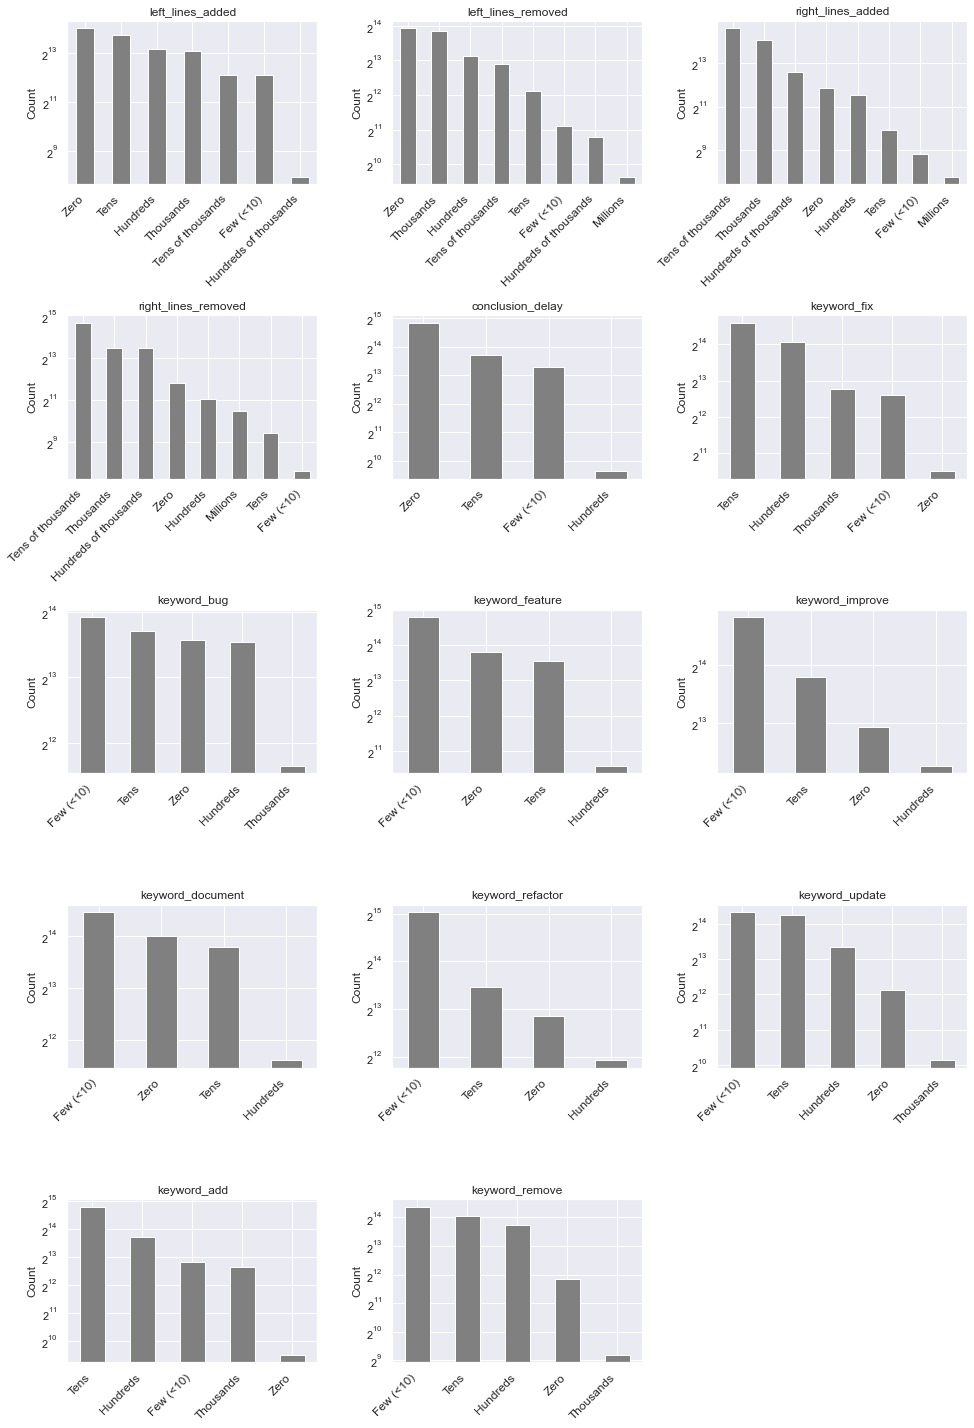

In [21]:
utils_attributes_analysis.count_plot_categorical(merge_columns_categorical_1, discretized, 3, True, 2)

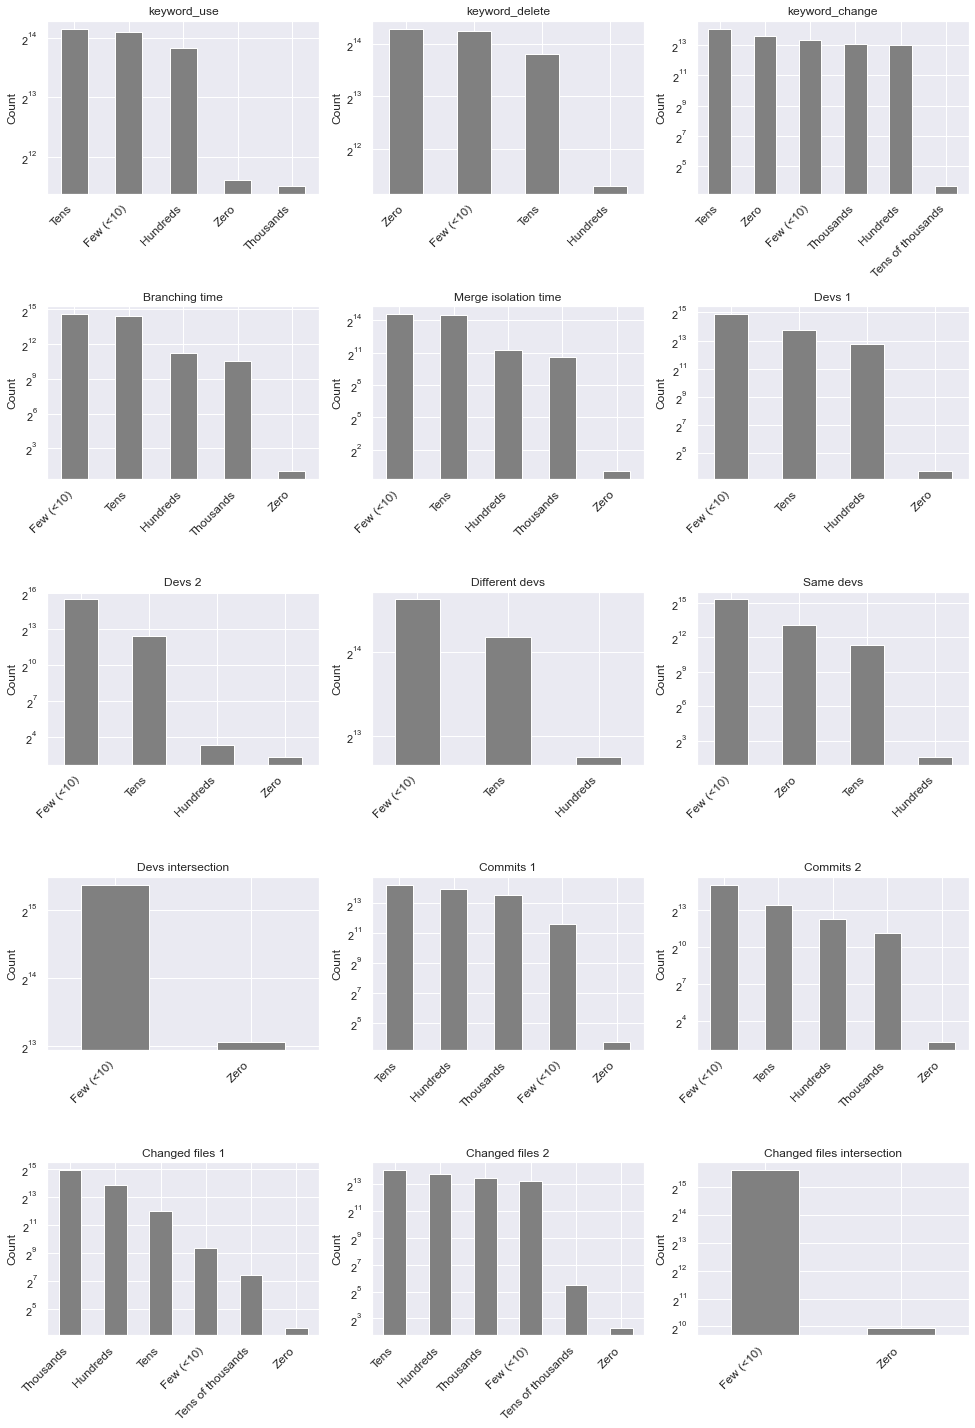

In [22]:
utils_attributes_analysis.count_plot_categorical(merge_columns_categorical_2, discretized, 3, True, 2)

### Lift analysis for Merge level attributes <a class="anchor" id="merge_lift"></a>

In [23]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in merge_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])    

In [24]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase[all_df_increase['Occurrences'] > 3].sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease[all_df_decrease['Occurrences'] > 3].sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,Changed files 2=Tens of thousands => Version 2,5.857075,0.977273,43
1,Devs 1=Zero => Manual,5.513756,0.615385,8
1,Changed files 1=Zero => Manual,5.513756,0.615385,8
1,Commits 1=Zero => Manual,5.513756,0.615385,8
0,right_lines_removed=Zero => Manual,4.218619,0.470836,1679
...,...,...,...,...
9,Changed files 1=Tens of thousands => Concatena...,1.510393,0.022989,4
12,right_lines_removed=Thousands => Combination,1.510190,0.100883,1142
11,left_lines_removed=Millions => Version 1,1.509678,0.953518,759
12,left_lines_removed=Hundreds => ConcatenationV1V2,1.505961,0.022921,207


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,left_lines_removed=Zero => ConcatenationV1V2,0.029369,0.000447,7
1,left_lines_removed=Zero => Combination,0.064046,0.004278,67
1,Changed files 2=Thousands => ConcatenationV2V1,0.091635,0.000536,6
1,right_lines_added=Zero => ConcatenationV1V2,0.106114,0.001615,6
0,right_lines_removed=Zero => ConcatenationV1V2,0.110548,0.001683,6
...,...,...,...,...
5,Branching time=Hundreds => Combination,0.488881,0.032658,79
10,right_lines_added=Hundreds of thousands => Ver...,0.489072,0.081603,511
13,right_lines_removed=Tens of thousands => Conca...,0.497822,0.002912,75
1,Commits 2=Thousands => Combination,0.498306,0.033288,73
